In [2]:
import io
import json
import boto3
import itertools
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import pyarrow as pa
import pyarrow.parquet as pq
import uuid
from io import StringIO
from botocore.exceptions import ClientError
from datetime import datetime
from types import SimpleNamespace
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# suppress irrelevant pandas warning
import warnings
warnings.filterwarnings('ignore', message='pandas only supports SQLAlchemy connectable')

In [3]:
class DataSource:
    def __init__(self, config):
        self.config = config
        self.connect()
    
    def connect(self):
        try:
            self.connection = psycopg2.connect(
                host=self.config.host,
                database=self.config.database,
                user=self.config.user,
                password=self.config.password,
                port=self.config.port
            )
            print("Connection to RDS successful")
        except Exception as e:
            print(f"Error connecting to RDS: {e}")
            
    def data(self, query, limit=100, offset=0):
        df = None
        try:
            query = f"SELECT * FROM ({query}) LIMIT {limit} OFFSET {offset}"
            df = pd.read_sql(query, self.connection)
        except Exception as e:
            print(f"Error querying data: {e}")
        return df
    
    def count(self, query):
        total_count = None
        try:
            count_query = f"SELECT COUNT(*) FROM ({query}) AS count_query"
            result = pd.read_sql(count_query, self.connection)
            total_count = result.iloc[0, 0]
        except Exception as e:
            print(f"Error querying count: {e}")
        return total_count

    def enrollment_query(self):
        query = """
        SELECT e.EnrollmentID, e.PersonalID, e.ProjectId, e.EntryDate, e.DateOfEngagement,
            CASE 
                WHEN e.LivingSituation = 116 THEN 'Place Not Meant For Habitation'
                WHEN e.LivingSituation = 101 THEN 'Emergency Shelter'
                WHEN e.LivingSituation = 118 THEN 'Safe Haven'
                WHEN e.LivingSituation = 215 THEN 'Foster Care Home'
                WHEN e.LivingSituation = 206 THEN 'Hospital/ Medical Facility'
                WHEN e.LivingSituation = 207 THEN 'Jail'
                WHEN e.LivingSituation = 225 THEN 'Long-term care facility'
                WHEN e.LivingSituation = 204 THEN 'Psychiatric hospital'
                WHEN e.LivingSituation = 205 THEN 'Substance abuse treatment facility'
                WHEN e.LivingSituation = 302 THEN 'Transitional Housing'
                WHEN e.LivingSituation = 329 THEN 'Halfway House'
                WHEN e.LivingSituation = 314 THEN 'Hotel/ Motel'
                WHEN e.LivingSituation = 332 THEN 'Host Home'
                WHEN e.LivingSituation = 312 THEN 'Staying or living with family, temporary tenure'
                WHEN e.LivingSituation = 313 THEN 'Staying or living with friends, temporary tenure'
                WHEN e.LivingSituation = 327 THEN 'HOPWA funded project TH'
                WHEN e.LivingSituation = 336 THEN 'Staying/ living in friends house'
                WHEN e.LivingSituation = 335 THEN 'Staying/ living in families house'
                WHEN e.LivingSituation = 422 THEN 'Staying or living with family, permanent tenure'
                WHEN e.LivingSituation = 423 THEN 'Staying or living with friends, permanent tenure'
                WHEN e.LivingSituation = 426 THEN 'HOPWA funded project PH'
                WHEN e.LivingSituation = 410 THEN 'Rental by client, no subsidy'
                WHEN e.LivingSituation = 435 THEN 'Rental by client, with subsidy'
                WHEN e.LivingSituation = 421 THEN 'Owned by client, no subsidy'
                WHEN e.LivingSituation = 411 THEN 'Owned by client, with subsidy'
                WHEN e.LivingSituation = 30  THEN 'No exit interview completed'
                WHEN e.LivingSituation = 17  THEN 'Other'
                WHEN e.LivingSituation = 24  THEN 'Deceased'
                WHEN e.LivingSituation = 37  THEN 'Unable to determine'
                WHEN e.LivingSituation = 8   THEN 'Client doesn''t know'
                WHEN e.LivingSituation = 9   THEN 'Client prefers not to answer'
                WHEN e.LivingSituation = 99  THEN 'Data Not Collected'
                WHEN e.LivingSituation IS NULL THEN 'Data Not Collected'
                ELSE 'Unknown'
            END AS LivingSituation,
            CASE
                WHEN e.LivingSituation >= 100 AND e.LivingSituation < 200 THEN 'Homeless Situation'
                WHEN e.LivingSituation >= 200 AND e.LivingSituation < 300 THEN 'Institutional Situation'
                WHEN e.LivingSituation >= 300 AND e.LivingSituation < 400 THEN 'Temporary Situation'
                WHEN e.LivingSituation >= 400 AND e.LivingSituation < 500 THEN 'Permanent Housing Situation'
                ELSE 'Other'
            END AS LivingSituationGrouping,
            x.ExitID, x.ExitDate,
            CASE
                WHEN x.Destination IS NULL THEN 99
                ELSE x.Destination
            END AS Destination,
            CASE
                WHEN x.Destination >= 100 AND x.Destination < 200 THEN 'Homeless Situation'
                WHEN x.Destination >= 200 AND x.Destination < 300 THEN 'Institutional Situation'
                WHEN x.Destination >= 300 AND x.Destination < 400 THEN 'Temporary Situation'
                WHEN x.Destination >= 400 AND x.Destination < 500 THEN 'Permanent Housing Situation'
                ELSE 'Other'
            END AS DestinationGrouping
        FROM Enrollment e
        INNER JOIN Exit x
            ON e.EnrollmentID = x.EnrollmentID
        ORDER BY e.EnrollmentID, e.PersonalID, e.ProjectID
        """
        return query
    
    def project_query(self):
        query = """
        SELECT
            p.ProjectID, p.ProjectType, p.ProjectName,
            CASE
                WHEN p.ProjectType = 0 THEN 'Emergency Shelter' --'Emergency Shelter Entry/Exit'
                WHEN p.ProjectType = 1 THEN 'Emergency Shelter' -- 'Emergency Shelter NightbyNight'
                WHEN p.ProjectType = 2 THEN 'Transitional Housing'
                WHEN p.ProjectType = 3 THEN 'Permanent Supportive Housing'
                WHEN p.ProjectType = 4 THEN 'Outreach'
                WHEN p.ProjectType = 6 THEN 'Services Only'
                WHEN p.ProjectType = 7 THEN 'Other'
                WHEN p.ProjectType = 8 THEN 'Safe Haven'
                WHEN p.ProjectType = 9 THEN 'Permanent Supportive Housing' -- 'Housing Only'
                WHEN p.ProjectType = 10 THEN 'Housing with Services'
                WHEN p.ProjectType = 11 THEN 'Day shelter'
                WHEN p.ProjectType = 12 THEN 'Homelessness Prevention'
                WHEN p.ProjectType = 13 THEN 'Permanent Supportive Housing' -- 'Rapid ReHousing'
                WHEN p.ProjectType = 14 THEN 'Coordinated entry'
                ELSE 'Unknown'
            END AS ProjectGroup
        FROM Project p
        WHERE
            p.ProjectType in (0, 1, 3, 4, 9, 11, 13)
        ORDER BY p.ProjectID
        """
        return query
    
    def client_query(self):
        query = """
        SELECT
            c.PersonalID, c.AmIndAKNative, c.Asian, c.BlackAfAmerican, c.HispanicLatinaeo, c.MidEastNAfrican,
            c.NativeHIPacific, c.White, COALESCE(c.RaceNone, 0) AS RaceNone, c.Woman, c.Man,
            c.NonBinary, c.CulturallySpecific, c.Transgender, c.Questioning, c.DifferentIdentity,
            COALESCE(c.GenderNone, 0) AS GenderNone, c.VeteranStatus, c.YearEnteredService,
            CASE
                WHEN CAST(RIGHT(c.DOB, 2) AS INT) > 24 THEN 2024 - (1900 + CAST(RIGHT(c.DOB, 2) AS INT))
                ELSE 2024 - (2000 + CAST(RIGHT(c.DOB, 2) AS INT))
            END AS EnrollmentAge,
            c.DOB, c.YearSeparated, c.DischargeStatus
        FROM Client c
        WHERE
            RIGHT(c.DOB, 2) <> 'yy'
        ORDER BY c.PersonalID
        """
        return query
    
    def health_query(self):
        query = """
        SELECT
            h.EnrollmentID,
            COALESCE(h.DomesticViolenceSurvivor, '99') AS DomesticViolenceSurvivor,
            COALESCE(h.CurrentlyFleeing, '99') AS CurrentlyFleeing,
            COALESCE(h.GeneralHealthStatus, '99') AS GeneralHealthStatus,
            COALESCE(h.PregnancyStatus, '99') AS PregnancyStatus,
            COALESCE(h.DentalHealthStatus, '99') AS DentalHealthStatus
        FROM HealthAndDV h
        WHERE
            h.DataCollectionStage = 1
        ORDER BY h.EnrollmentID
        """
        return query
    
    def disability_query(self):
        query = """
        SELECT
            EnrollmentID,
            MAX(CASE WHEN DisabilityType = 5 THEN DisabilityResponse ELSE 0 END) AS PhysicalDisability,
            MAX(CASE WHEN DisabilityType = 6 THEN DisabilityResponse ELSE 0 END) AS DevelopmentalDisability,
            MAX(CASE WHEN DisabilityType = 7 THEN DisabilityResponse ELSE 0 END) AS ChronicHealthCondition,
            MAX(CASE WHEN DisabilityType = 8 THEN DisabilityResponse ELSE 0 END) AS HIV_AIDS,
            MAX(CASE WHEN DisabilityType = 9 THEN DisabilityResponse ELSE 0 END) AS MentalHealthDisorder,
            MAX(CASE
                WHEN DisabilityType = 10 AND DisabilityResponse = 1 THEN 1
                ELSE 0
            END) AS AlcoholUseDisorder,
            MAX(CASE
                WHEN DisabilityType = 10 AND DisabilityResponse = 2 THEN 1
                ELSE 0
            END) AS DrugUseDisorder,
            MAX(CASE
                WHEN DisabilityType = 10 AND DisabilityResponse = 3 THEN 1
                ELSE 0
            END) AS AlcoholAndDrugUseDisorder
        FROM Disabilities
        WHERE DataCollectionStage = 1
        GROUP BY EnrollmentID
        ORDER BY EnrollmentID
        """
        return query
    
    def education_query(self):
        query = """
        SELECT
            ee.EnrollmentID,
            CASE
                WHEN ee.LastGradeCompleted = 1 THEN 'Less than Grade 5'
                WHEN ee.LastGradeCompleted = 2 THEN 'Grade 5-6'
                WHEN ee.LastGradeCompleted = 3 THEN 'Grade 7-8'
                WHEN ee.LastGradeCompleted = 4 THEN 'Grade 9-11'
                WHEN ee.LastGradeCompleted = 5 THEN 'Grade 12'
                WHEN ee.LastGradeCompleted = 6 THEN 'School with no grade levels'
                WHEN ee.LastGradeCompleted = 7 THEN 'GED'
                WHEN ee.LastGradeCompleted = 8 THEN 'Client Doesn''t Know'
                WHEN ee.LastGradeCompleted = 9 THEN 'Client Prefers Not to Answer'
                WHEN ee.LastGradeCompleted = 10 THEN 'Some College'
                WHEN ee.LastGradeCompleted = 11 THEN 'Associate''s Degree'
                WHEN ee.LastGradeCompleted = 12 THEN 'Bachelor''s Degree'
                WHEN ee.LastGradeCompleted = 13 THEN 'Graduate Degree'
                WHEN ee.LastGradeCompleted = 14 THEN 'Vocational certification'
                ELSE 'Data not collected'
            END AS LastGradeCompleted
        FROM EmploymentEducation ee
        WHERE
            ee.DataCollectionStage = 1
        ORDER BY ee.EnrollmentID
        """
        return query

    def income_query(self):
        query = """
        SELECT
            ib.EnrollmentID,
            COALESCE(ib.IncomeFromAnySource, '99') AS IncomeFromAnySource,
            ib.TotalMonthlyIncome,
            COALESCE(ib.BenefitsFromAnySource, '99') AS BenefitsFromAnySource,
            COALESCE(ib.InsuranceFromAnySource, '99') AS InsuranceFromAnySource
        FROM IncomeBenefits ib
        WHERE
            ib.DataCollectionStage = 1
        ORDER BY ib.EnrollmentID
        """
        return query
    
    def income_exit_query(self):
        query = """
        SELECT
            ib_exit.EnrollmentID,
            COALESCE(ib_exit.IncomeFromAnySource, '99') AS ExitIncomeFromAnySource,
            ib_exit.TotalMonthlyIncome AS ExitTotalMonthlyIncome,
            COALESCE(ib_exit.BenefitsFromAnySource, '99') AS ExitBenefitsFromAnySource,
            COALESCE(ib_exit.InsuranceFromAnySource, '99') AS ExitInsuranceFromAnySource
        FROM IncomeBenefits ib_exit
        WHERE
            ib_exit.DataCollectionStage = 3
        ORDER BY ib_exit.EnrollmentID
        """
        return query
    
    def services_query(self):
        query = """
        SELECT
            EnrollmentID,
            SUM(BasicNeedsService) AS BasicNeedsService,
            SUM(CaseManagementService) AS CaseManagementService,
            SUM(BenefitsAssistanceService) AS BenefitsAssistanceService,
            SUM(PermanentHousingGuidanceService) AS PermanentHousingGuidanceService,
            SUM(FinancialSupportService) AS FinancialSupportService,
            SUM(MoveInAndRentalAssistanceService) AS MoveInAndRentalAssistanceService,
            SUM(TravelService) AS TravelService,
            SUM(FamilyServicesService) AS FamilyServicesService,
            SUM(HarmAndCrisisInterventionService) AS HarmAndCrisisInterventionService,
            SUM(FoodAndWaterService) AS FoodAndWaterService,
            SUM(MentalHealthSupportService) AS MentalHealthSupportService,
            SUM(SubstanceAbuseSupportService) AS SubstanceAbuseSupportService,
            SUM(HealthCareAssistanceService) AS HealthCareAssistanceService,
            SUM(EmploymentSupportService) AS EmploymentSupportService,
            SUM(EducationSupportService) AS EducationSupportService,
            SUM(TemporaryHousingGuidanceService) AS TemporaryHousingGuidanceService
        FROM (
            SELECT
                EnrollmentID,
                CASE
                    WHEN RecordType = 200 AND TypeProvided = 200 THEN 1
                    ELSE 0
                    END AS BasicNeedsService,
                CASE
                    WHEN RecordType = 141 AND TypeProvided = 1 THEN 1
                    WHEN RecordType = 144 AND TypeProvided IN (0, 1) THEN 1
                    ELSE 0
                    END AS CaseManagementService,
                CASE
                    WHEN RecordType = 144 AND TypeProvided IN (3, 4, 6) THEN 1
                    ELSE 0
                    END AS BenefitsAssistanceService,
                CASE
                    WHEN RecordType = 144 AND TypeProvided IN (8, 9) THEN 1
                    WHEN RecordType = 152 AND TypeProvided = 12 THEN 1
                    WHEN RecordType = 161 AND TypeProvided = 5 THEN 1
                    ELSE 0
                    END AS PermanentHousingGuidanceService,
                CASE
                    WHEN RecordType = 144 AND TypeProvided = 7 THEN 1
                    WHEN RecordType = 152 AND TypeProvided = 14 THEN 1
                    WHEN RecordType = 161 AND TypeProvided = 8 THEN 1
                    ELSE 0
                    END AS FinancialSupportService,
                CASE
                    WHEN RecordType = 152 AND TypeProvided IN (1, 2, 3, 4, 5, 17, 18) THEN 1
                    ELSE 0
                    END AS MoveInAndRentalAssistanceService,
                CASE
                    WHEN RecordType = 152 AND TypeProvided IN (8, 9) THEN 1
                    ELSE 0
                    END AS TravelService,
                CASE
                    WHEN RecordType = 152 AND TypeProvided = 10 THEN 1
                    ELSE 0
                    END AS FamilyServicesService,
                CASE
                    WHEN RecordType = 152 AND TypeProvided = 14 THEN 1
                    ELSE 0
                    END AS HarmAndCrisisInterventionService,
                CASE
                    WHEN RecordType = 152 AND TypeProvided = 16 THEN 1
                    ELSE 0
                    END AS FoodAndWaterService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided = 1 THEN 1
                    ELSE 0
                    END AS MentalHealthSupportService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided = 2 THEN 1
                    ELSE 0
                    END AS SubstanceAbuseSupportService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided IN (3, 10) THEN 1
                    ELSE 0
                    END AS HealthCareAssistanceService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided IN (4, 9) THEN 1
                    ELSE 0
                    END AS EmploymentSupportService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided IN (6, 7) THEN 1
                    ELSE 0
                    END AS EducationSupportService,
                CASE
                    WHEN RecordType = 161 AND TypeProvided = 11 THEN 1
                    ELSE 0
                    END AS TemporaryHousingGuidanceService
            FROM Services
        ) AS TempServices
        GROUP BY EnrollmentID
        ORDER BY EnrollmentID
        """
        return query
    
    def custom_services_query(self):
        query = """
        SELECT
            EnrollmentID, PersonalID,
            SUM(CASE
                WHEN ServiceItemName IN ('Automobile Repair', 'Bus Pass', 'Bus Tokens', 'Buss Pass', 'Car Repairs', 'DMV Voucher', 'Direct Transportation', 'Gas Card', 'Metro Fare', 'Metro Pass', 'Non-SSVF Transportation Services', 'Non-SSVF Transportation: Tokens/Vouchers', 'Rid Service (ACCESS, Dial-a-Ride, Lyft/Uber, Medical Insurance', 'Ride Service (ACCESS, Dial a Ride, Lyft/Uber)', 'Ride Service (ACCESS, Dial a Ride, Lyft/Uber, Medical Insurance)', 'Ride Service (ACCESS, Dial-a-Ride, Lyft/Uber, Medical Insurance)', 'Ride Services', 'TAP Card', 'TAP Card Application', 'Taxi Voucher', 'Taxi Vouchers', 'Transportation', 'Transportation Assistance - Bus Pass', 'Transportation Assistance - Gas', 'Transportation Assistance - Lyft/Uber', 'Transportation Assistance - Reunification', 'Transportation Assistance - Vehicle Fees/Repairs', 'Transportation to Relocate', 'Travel Assistance', 'Truck Rental and Labor Costs') THEN Quantity
                ELSE 0
            END) AS TravelAssistanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('Computer Use', 'Employment', 'Employment Assistance', 'Employment Development', 'Employment Services', 'Interview Clothes and Materials', 'Interview Clothes/Materials', 'Interview Clothing and Materials', 'Interview Clothing/Materials', 'Interview Skills', 'Job Necessities', 'Job Referral', 'Job Search Assistance', 'Job Training', 'Opportunity Center', 'Resume and Application Support', 'Resume/Cover Letter Development', 'Resume/cover Letter Development', 'Short Term Training Cost', 'Vocational', 'Vocational Counseling', 'Work Clothing/Tools') THEN Quantity
                ELSE 0
            END) AS EmploymentSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Basic Needs', 'Basic Needs/Rapport Building - Clothing', 'Basic Needs/Rapport Building - Food Expenses', 'Basic Needs/Rapport Building - Medical Expenses', 'Basic Needs/Rapport Building - Phone/Phone Service', 'Basic Needs/Services', 'Basic needs', 'Bedding', 'Beds', 'Cleaning Services', 'Cleaning Supplies', 'Clothing', 'Clothing Card', 'Congregate Meals/Nutrition Sites', 'Donations', 'Donner', 'Education or Connection to Clothing Resources', 'Education or Connection to Food Bank Resources', 'Electric/Outdoor Supplies/Misc', 'Laundry', 'Mail Service', 'Material Goods', 'Other Basic Needs', 'Showers', 'Sleeping Bag', 'Supply Distribution', 'Tent') THEN Quantity
                ELSE 0
            END) AS BasicNeedsService,
            SUM(CASE
                WHEN ServiceItemName IN ('Bottled Water', 'Breakfast', 'Dinner', 'Food', 'Food - COVID Americas Best Value Inn Tier 1', 'Food - COVID LA Best Western Plus South Bay Tier 1', 'Food - COVID Motel 6 Rosemead', 'Food - PHK Ramada', 'Food Distribution', 'Food Gift Card', 'Food and Drink', 'Food and Drink Items', 'Food and Nutrition', 'Food and Supplies', 'Food/Drink Items', 'Grocery Card', 'Grocery Cards', 'Lunch', 'Meal Card', 'Meal Delivery', 'Meals', 'Water') THEN Quantity
                ELSE 0
            END) AS FoodAndWaterService,
            SUM(CASE
                WHEN ServiceItemName IN ('Basic Supplies and Hygeine Items', 'Basic Supplies and Hygiene Items', 'Basic and Hygiene Items', 'Hygiene Kit', 'Hygiene Kits', 'Hygiene Supplies', 'Hygiene, Clothing, and Sleeping', 'Hyigene Kit') THEN Quantity
                ELSE 0
            END) AS HygieneSuppliesService,
            SUM(CASE
                WHEN ServiceItemName IN ('Birth Certificate', 'Birth Certificate Voucher', 'Document Assistance', 'Drivers License/Birth Certificate', 'Homeless Verification', 'ID/Drivers License', 'Identification', 'Licenses/Fees', 'Passport', 'Permanent Resident Card', 'Social Security Card', 'Yes - Has Valid ID (Program Assisted in Obtaining ID)', 'Yes - Has Valid ID (Program Did Not Assist in Obtaining ID)', 'Yes - Has Valid SSN Card (Program Assisted in Obtaining SSN Card)', 'Yes - Has Valid SSN Card (Program Did Not Assist in Obtaining SSN Card)') THEN Quantity
                ELSE 0
            END) AS DocumentSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Actual Release Date', 'Annual Assessment', 'Annual Recertification Support', 'Attended with Client', 'Briefing Completed', 'CARE Case Management', 'CARE Outreach and Engagement', 'Case Consultation Follow-Up', 'Case Management', 'Case Managment', 'Case/Care Management', 'Client Interaction - No Services/Referrals Provided', 'CoC HEAP Service Encounter', 'Complete Intake Application Received', 'Contacts', 'Contacts - In Person', 'Contacts - Phone', 'Count Client in HDAP Report', 'Discharge Planning', 'Dispute Resolution', 'Enrollments', 'Folllow-Up', 'Follow-Up', 'HRC Case Management', 'Housing-Focused Case Management', 'Initial Application', 'Intake and Assessment', 'Locate Client Before Enrolling in CCP', 'Locating Referrals', 'Missing Client Search', 'Mobile Case Management', 'No - Does Not Have Valid ID', 'No - Does Not Have Valid SSN Card', 'No contact in person', 'No contact phone call', 'Not Attained', 'Not Staying on Streets, ES, or SH', 'Not staying on Streets, ES, or SH', 'Off-Site Case Management', 'On-Site Case Management', 'Outreach', 'Place not meant for habitation', 'Program Incentives', 'Record Case Management services while client is in the program', 'Record case management services while client is in the Housing Maintenance program', 'Record case management services while client is in the program', 'Resolution Strategies - HHAP', 'Resolution Strategies Service Transaction', 'SCCWRP Survey', 'Schedule for/or with Client', 'Staying on Streets, ES or SH', 'Staying on Streets, ES, or SH', 'Targeted Case Management', 'VI-SPDAT', 'Wellness Check', 'Whole Person Wellness Referral', 'Worker unable to determine', '[HomeFirst] Case Management', '[VWP] Mobile Case Management') THEN Quantity
                ELSE 0
            END) AS CaseManagementService,
            SUM(CASE
                WHEN ServiceItemName IN ('Behavioral Counseling/Encouragement', 'Connect to Behavioral Health Services', 'Individual counseling', 'Mental Health', 'Mental Health Care Referral', 'Mental Health Clinical Services', 'Mental Health Services', 'Mental Health Supportive Services', 'Psychiatrist Evaluation', 'Psychiatrist Therapy') THEN Quantity
                ELSE 0
            END) AS MentalHealthSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Emotional Support/Service Animal Certification', 'Housing Assistance - Pet Expenses', 'Pet Food', 'Pet Supplies', 'Pet Support', 'Veterinary Services') THEN Quantity
                ELSE 0
            END) AS PetSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Basic Skills Training','Life Skills','Life Skills Workshop','Personal Development','Personal Enrichment') THEN Quantity
                ELSE 0
            END) AS LifeSkillsService,
            SUM(CASE
                WHEN ServiceItemName IN ('Activities', 'C3 Center Group Attendance', 'Communication Support with Property Management', 'Community Engagement', 'Community Groups', 'Group Rehabilitation', 'Group Therapy', 'Immanuel Sobrato Community', 'Supportive Groups', 'Supportive Services', 'Supportive Services Groups') THEN Quantity
                ELSE 0
            END) AS CommunitySupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Alcohol and Drug Abuse', 'Alcohol and Drug Abuse Services', 'Detox Services', 'Drug Treatment', 'Harm Reduction &amp; General Substance Use Education', 'Naloxone Distributed with Education', 'Narcan/Nalaxone', 'Narcan/Naloxone', 'Needle Exchange', 'Substance Use Counseling', 'Substance Use Services', 'Toxic Screen') THEN Quantity
                ELSE 0
            END) AS SubstanceAbuseSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('CARE Clinical Case Manager', 'CalAim', 'Caregiver Services/Respite', 'Clinical Case Management', 'Connect to Medical Home', 'HIV/AIDS - Related Services', 'Health Care Referral', 'Health Homes Program Referral', 'Home Health Care/Outpatient', 'Medi-Cal Application', 'Medical', 'Medical Care', 'Medical Services', 'Medical Services - Primary Care/Specialized Care/FQHC', 'Medication Evaluation', 'Other Health Care', 'Other Health Care Services', 'Outpatient Medical Services', 'Pharmaceuticals', 'Physical Health', 'Physical Health Provider', 'Physical Health Provider r', 'Physical Health Support', 'Primary Care', 'Specialty Care') THEN Quantity
                ELSE 0
            END) AS HealthCareAssistanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('Veteran Services', 'Veterans Services') THEN Quantity
                ELSE 0
            END) AS VeteranServicesService,
            SUM(CASE
                WHEN ServiceItemName IN ('Connection to Legal Aid','Court Documents','Legal','Legal Fees','Legal Services','court Documents') THEN Quantity
                ELSE 0
            END) AS LegalSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Assistance Obtaining Insurance', 'Assistance obtaining/coordinating public benefits', 'Benefit Assistance', 'Benefit Service', 'Benefits', 'Benefits Assessment', 'Benefits Assistance', 'Benefits/Income Verification', 'CARE Benefits Assessment', 'Documents and Benefits', 'GR Assistance', 'Public Benefits', 'Support in Obtaining Benefits') THEN Quantity
                ELSE 0
            END) AS BenefitsAssistanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('COVID - SMS Tool', 'COVID Education', 'COVID PPE', 'COVID SMS Tool', 'COVID Shelter In Place Support', 'COVID Testing', 'COVID Testing Support', 'COVID Testing/Vaccine Follow-Up', 'COVID Triage Tool', 'COVID Vaccine Support', 'PPE') THEN Quantity
                ELSE 0
            END) AS CovidSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Developmental Disability', 'Physical Disability', 'Physical Disability Services', 'Support with Reasonable Accommodation Requests', 'Verification of Disability') THEN Quantity
                ELSE 0
            END) AS DisabilitySupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Education', 'Educational Services', 'Linkage to Education Resources', 'Linkage to Employment/Employment Services', 'School Supplies') THEN Quantity
                ELSE 0
            END) AS EducationSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Application Fee', 'Application Fee Assistance', 'Application Fees', 'Arrears', 'Background Check Fee', 'Budget Creation', 'Coupon Issuance', 'Deposit', 'Document Fee', 'Enrollment Fee/Deposit', 'Financial Assistance', 'Financial Assistance - Other', 'Gift Card', 'Gift Card(s)', 'Holding Fee', 'Housing Assistance - Document Processing Fees', 'Incentive Fee', 'Late Fee', 'Late Fees', 'Met Income Target', 'SCCWRP Gift Card', 'Temporary financial assistance') THEN Quantity
                ELSE 0
            END) AS FinancialSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Credit Check Score Fee', 'Credit Counseling and Financial Literacy Training', 'Education Regarding Credit Repair', 'Housing Assistance - Credit Repair') THEN Quantity
                ELSE 0
            END) AS CreditSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Child Care', 'Child Care Assistant', 'Family Reunification', 'Family Services', 'Households with Children', 'Households without Children', 'Parenting Programs', 'Reunification Services') THEN Quantity
                ELSE 0
            END) AS FamilyServicesService,
            SUM(CASE
                WHEN ServiceItemName IN ('211 Motel/Hotel Vouchers', 'Appliances', 'Broker Fee', 'EOT Motel Assistance', 'Enter Tenants Portion of the Rent', 'Essential Furnishings', 'Essential Furnishngs', 'Furniture Assistance', 'HQS Inspection Completed', 'Holding Fee', 'Home Modifications', 'Host Stipend', 'Hotel/Motel Voucher', 'Housing Assistance - Moving, Move-in, and Storage Costs', 'Housing Assistance - Rental Assistance', 'Housing Assistance - Utility Assistance', 'Housing Services - Debt Relief/Landlord Mitigation', 'Housing Services - Rent/Security Deposit/Utilities/Application Fees', 'Landlord Incentive Fee', 'Landlord Incentive\xa0Fee', 'Landlord Insentive Fee', 'Landlord Mediation', 'Misc. Housing Cost', 'Motel/Hotel Voucher', 'Motel/Hotel Vouchers', 'Moving Cost Assistance', 'Moving Cost Assitance', 'Moving Costs Assistance', 'Moving Expense Assistance', 'Moving Fees', 'Moving costs Assistance', 'Non-SSVF Moving Cost Assistance', 'Non-SSVF Rental Assistance', 'Non-SSVF Security Deposit', 'Non-SSVF Utility Payments', 'Other Document Fees', 'Other Financial Assistance', 'Partial Rental Assistance', 'Pedro Street A: Housing Tenancy and Sustaining Services', 'Pedro Street B: Interventions Towards Sustaining Housing', 'Pedro Street C: Housing Interventions and Retention', 'Pedro Street D: Move in and Housing Retention', 'Relocation Assistance', 'Rental Arrears', 'Rental Assistance', 'Rental Deposit Assistance', 'Rental Insurance', 'Security Deposit', 'Storage', 'Storage Fee', 'Storage Fees', 'Tenant Screening Reports', 'Utilities', 'Utility Arrears', 'Utility Assistance', 'Utility Deposit', 'Utility Fee Assistance', 'Utility Payments', 'Utility Service Payment Assistance') THEN Quantity
                ELSE 0
            END) AS MoveInAndRentalAssistanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('Crisis Housing', 'Crisis Intervention', 'Emergency Reponse', 'Emergency Response', 'Harm Reducation', 'Harm Reduction', 'Harm Reduction Supplies/Education', 'SDPD') THEN Quantity
                ELSE 0
            END) AS HarmAndCrisisInterventionService,
            SUM(CASE
                WHEN ServiceItemName IN ('Temporary Housing', 'Temporary Housing Placement', 'Temporary Housing Support', 'Temporary Shelter Need and Requested') THEN Quantity
                ELSE 0
            END) AS TemporaryHousingGuidanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('Housing And Services Plan', 'Housing Navigation', 'Housing Planning/Placement', 'Housing Problem Solving', 'Housing Search', 'Housing Search and Information', 'Housing Search and Placement', 'Housing Service Plan', 'Housing Stability Plan', 'Housing Stabilization', 'Housing and Service Plan', 'Housing and Services Plan', 'Housing search and Placement', 'Record the time the client searches for an apartment', 'Referral - Housing Navigation', 'Services - Housing Navigation') THEN Quantity
                ELSE 0
            END) AS HousingSearchService,
            SUM(CASE
                WHEN ServiceItemName IN ('Homeless Permanent Supportive Housing', 'Housing', 'Housing Referral', 'Non-SSVF General Housing Stability Assistance - Other', 'Other Housing', 'PSH Connection', 'Permanent Housing', 'Permanent Housing Placement', 'Rapid Re-Housing', 'Rapid Re-Housing Program', 'Rapid Re-Housing Programs', 'Rapid Rehousing', 'Rapid Resolution', 'Scattered Site - Mehta Properties', 'Scattered Site - Other', 'Stabilization Vouchers HCV') THEN Quantity
                ELSE 0
            END) AS PermanentHousingGuidanceService,
            SUM(CASE
                WHEN ServiceItemName IN ('CARE Shelter Placement', 'Interim Housing', 'Legitimate Shelter Referral', 'Pedro Street Interim Housing', 'Shelter Placement', 'Shelter Referral', 'Shelter Referrals', 'Transitional Housing/Shelter', '[VWP] Shelter Placement') THEN Quantity
                ELSE 0
            END) AS ShelterSupportService,
            SUM(CASE
                WHEN ServiceItemName IN ('Agrihood Senior PBV', 'Appeal', 'Attained', 'Belovida', 'Blossom Hill PBV', 'Bridge Housing', 'C3 Center Drop-In', 'Calabazas Apartments', 'Casa de Novo - PBV', 'Casa de Novo - PWH', 'Connected to HRC On-Site Partner', 'Consumer Assistance and Protection', 'Corie Court', 'Curtner - General Population', 'Curtner - MHSA', 'Curtner - PWH', 'DD214', 'Denial', 'Downtown Core', 'Eagle Park', 'Education Regarding Tennant Rights', 'Edwina Benner Plaza', 'Ford Road', 'Gilroy Gateway Seniors', 'Gilroy Sobrato', 'Guadalupe', 'Guadalupe North', 'Guadalupe South', 'HALA', 'HOME', 'HRC Service Coordination', 'Here4You Referral', 'Hillview Court', 'Hillview PBV', 'HomeFirst SJ Citywide Encampments', 'ICS', 'Individuals', 'Information and Referral', 'Information and Referrals', 'Kifer Senior PBV', 'Laurel Grove', 'Lease Info', 'Leigh Ave PBV', 'Linkage', 'Linkage to Payee Programs', 'MLK Library', 'Mainstream 811 Program', 'Onizuka', 'Orchard Ranch', 'Other', 'Other (Outside of San Jose)', 'Other Service Referral', 'Other Services', 'PATH', 'Page Street PBV', 'Park Avenue Senior PBV', 'Parkside', 'Paseo Center', 'Paseo Senter', 'Problem Solving', 'Quetzal Gardens', 'Reconsideration', 'Referral', 'Referral - Access Center', 'Referral Made', 'Referral made', 'Referral to MHRT', 'Referrals and Linkage', 'Renascent Place', 'San Jose', 'Sango Court Apartments PBV', 'Second Street Studios', 'Senter Road', 'Service Information/Brochures', 'Service setting, non-residential', 'Service setting, residential', 'Services Information/Brochures', 'The Crossing on Monterey', 'The Jungle', 'The Veranda', 'Tully Area', 'Tully Gardens', 'Vela Apartments', 'Villas 4th HCMH PBV', 'Villas 4th MRR PBV', 'Villas on the Park', '[CCP Housing Maintenance] CHDR 2016', '[CCP Pre-Housing ICM] Encampment ICM', '[SOAR] Outreach') THEN Quantity
                ELSE 0
            END) AS ReferralLinkageInformationService
        FROM (
            SELECT
                ClientID AS PersonalID, ClientProgramID AS EnrollmentID, REGEXP_REPLACE(TRIM(ServiceItemName), '\s+', ' ') as ServiceItemName, COUNT(*) as Quantity
            FROM CustomClientServices
            GROUP BY ClientID, ClientProgramID, ServiceItemName
        ) as TempCustomServices
        GROUP BY EnrollmentID, PersonalID
        ORDER BY EnrollmentID, PersonalID
        """
        return query
    
    def additional_information_query(self):
        query = """
        SELECT
            ai.EnrollmentID,
            CASE
                WHEN ChronicallyHomeless = 1 THEN 1
                ELSE 0
            END AS ChronicallyHomeless
        FROM AdditionalInformation ai
        ORDER BY ai.EnrollmentID
        """
        return query
    
    def outbound_recidivism_query(self):
        query = """
        SELECT
            ob.EnrollmentID,
            CASE
                WHEN AppearsWOStableHousing = 'Yes' THEN 1
                ELSE 0
            END AS AppearsWOStableHousing
        FROM OutboundRecidivism ob
        ORDER BY ob.EnrollmentID
        """
        return query
    
    def log_experiment(
        self,
        model_type: str,
        hyperparameters: dict,
        training_data_version: str,
        performance_metrics: dict,
        s3_model_location: str,
        start_time: datetime,
        end_time: datetime,
        status: str,
        notes: str
    ):
        """
        Logs an experiment to the PostgreSQL database.

        Parameters:
        - model_type (str): The type of the model (e.g., 'RandomForest', 'GBM').
        - hyperparameters (dict): A dictionary of hyperparameters used for the model.
        - training_data_version (str): The version of the training data.
        - performance_metrics (dict): A dictionary of performance metrics (e.g., accuracy, F1 score).
        - s3_model_location (str): The S3 location where the model weights are stored.
        - start_time (datetime): The start time of the experiment.
        - end_time (datetime): The end time of the experiment.
        - status (str): The status of the experiment (e.g., 'Completed', 'Failed').
        - notes (str): Any additional notes for the experiment.

        Returns:
        - None: Logs the experiment in the database.
        """
        cursor = self.connection.cursor()
        insert_query = """
            INSERT INTO experiments (
                model_type, 
                hyperparameters, 
                training_data_version, 
                performance_metrics, 
                s3_model_location, 
                start_time, 
                end_time, 
                status, 
                notes
            ) 
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """

        # Execute the insert query
        cursor.execute(insert_query, (
            model_type, 
            json.dumps(hyperparameters), 
            training_data_version, 
            json.dumps(performance_metrics), 
            s3_model_location, 
            start_time, 
            end_time, 
            status, 
            notes
        ))

        self.connection.commit()

In [4]:
class DataRetriever:
    def __init__(self, data_source, max_count=None):
        self.data_source = data_source
        # using a max_count can be convenient when debugging and wanting to limit data size
        self.max_count = max_count
        
    def records(self):
        if self.max_count:
            print(f'Using max_count = {self.max_count}')
            
        enrollments = self.fetch(self.data_source.enrollment_query())
        projects = self.fetch(self.data_source.project_query())
        clients = self.fetch(self.data_source.client_query())
        health = self.fetch(self.data_source.health_query())
        disability = self.fetch(self.data_source.disability_query())
        education = self.fetch(self.data_source.education_query())
        income = self.fetch(self.data_source.income_query())
        income_exit = self.fetch(self.data_source.income_exit_query())
        services = self.fetch(self.data_source.services_query())
        custom_services = self.fetch(self.data_source.custom_services_query())
        additional_information = self.fetch(self.data_source.additional_information_query())
        outbound_recidivism = self.fetch(self.data_source.outbound_recidivism_query())
        
        all_data = pd.merge(enrollments, projects, on='projectid', how='inner')
        all_data = pd.merge(all_data, clients, on='personalid', how='inner')
        all_data = pd.merge(all_data, health, on='enrollmentid', how='inner')
        all_data = pd.merge(all_data, education, on='enrollmentid', how='inner')
        all_data = pd.merge(all_data, income, on='enrollmentid', how='inner')
        all_data = pd.merge(all_data, income_exit, on='enrollmentid', how='inner')
        all_data = pd.merge(all_data, disability, on='enrollmentid', how='left')
        all_data = pd.merge(all_data, services, on='enrollmentid', how='left')
        all_data = pd.merge(all_data, custom_services, on='enrollmentid', how='left', suffixes=('', '_cs'))
        all_data = pd.merge(all_data, additional_information, on='enrollmentid', how='left')
        all_data = pd.merge(all_data, outbound_recidivism, on='enrollmentid', how='left')
            
        return all_data
        
    def fetch(self, query):
        total_count = self.data_source.count(query)

        if total_count is None:
            print("Failed to retrieve total count.")
            return None

        if self.max_count and total_count > self.max_count:
            total_count = self.max_count
        
        all_data = pd.DataFrame()
        batch_size = 10000
        
        try:
            for offset in range(0, total_count, batch_size):
                last_idx = min(offset + batch_size, total_count)
                print(f"Fetching {offset} to {last_idx} of {total_count}")
                data = self.data_source.data(query, limit=batch_size, offset=offset)
                all_data = pd.concat([all_data, data], ignore_index=True)
        except Exception as e:
            print(f"Error querying data: {e}")

        return all_data

In [5]:
class DataInspector:
    def display(self, data, columns):
        styled_df = data[[col for col in columns]].head().style.set_table_styles([{
            'selector': 'table',
            'props': [('max-width', '1000px'), ('overflow-x', 'scroll'), ('display', 'block')]
        }])

        display(styled_df)
        print(f"Total count: {len(data)}")
    
    def display_full(self, data, columns):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            styled_df = data[[col for col in columns]].style.set_table_styles([{
                'selector': 'table',
                'props': [('max-width', '1000px'), ('overflow-x', 'scroll'), ('display', 'block')]
            }])

            display(styled_df)
        print(f"Total count: {len(data)}")    

    def visualize_correlation_matrix(self, data):
        correlation_matrix = data.corr()
        plt.figure(figsize=(10, 8))
        plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')
        plt.colorbar()
        plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=90)
        plt.yticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns)
        plt.title("Correlation Matrix", pad=20)
        plt.show()

In [6]:
class S3:
    def __init__(self, bucket_name):
        self.bucket_name = bucket_name
        self.s3 = boto3.client('s3')
        
    def save_model(self, model, name):
        model_buffer = io.BytesIO()
        joblib.dump(model, model_buffer)
        model_buffer.seek(0)
        try:
            file_key = f"models/{name}.joblib"
            self.s3.upload_fileobj(model_buffer, self.bucket_name, file_key)
            print(f"Model successfully uploaded to s3://{self.bucket_name}/{file_key}")
            return f"s3://{self.bucket_name}/{file_key}"
        except Exception as e:
            print(f"Failed to upload model to S3: {e}")
            return None
        
    def save_label_encoders(self, label_encoders, name):
        data_buffer = io.BytesIO()
        joblib.dump(label_encoders, data_buffer)
        data_buffer.seek(0)
        try:
            file_key = f"datasets/{name}/label_encoders.joblib"
            self.s3.upload_fileobj(data_buffer, self.bucket_name, file_key)
            print(f"Label Encoder successfully uploaded to s3://{self.bucket_name}/{file_key}")
            return f"s3://{self.bucket_name}/{file_key}"
        except Exception as e:
            print(f"Failed to read label encoder model from S3: {e}")
            return None
    
    def read_label_encoders(self, name):
        try:
            file_key = f"datasets/{name}/label_encoders.joblib"
            data_buffer = io.BytesIO()
            self.s3.download_fileobj(self.bucket_name, file_key, data_buffer)
            data_buffer.seek(0)
            label_encoders = joblib.load(data_buffer)
            print(f"Label Encoder successfully loaded from s3://{self.bucket_name}/{file_key}")
            return label_encoders
        except Exception as e:
            print(f"Failed to upload label encoder model to S3: {e}")
            return None
        
    def read_dataset(self, name):
        base_key = f"datasets/{name}"
        
        # check for the last file written... hack
        if not self.key_exists(f"{base_key}/y_test"):
            return None
        
        dataset = Dataset()

        dataset.X_train = self.read_dataset_df(f"{base_key}/X_train")
        dataset.X_val   = self.read_dataset_df(f"{base_key}/X_val")
        dataset.X_test  = self.read_dataset_df(f"{base_key}/X_test")
        
        # the label is a Series, so get the first column from the saved dataframe
        dataset.y_train = self.read_dataset_df(f"{base_key}/y_train").iloc[:, 0]
        dataset.y_val   = self.read_dataset_df(f"{base_key}/y_val").iloc[:, 0]
        dataset.y_test  = self.read_dataset_df(f"{base_key}/y_test").iloc[:, 0]
        
        return dataset
    
    def read_dataset_df(self, file_key):
        dataset_buffer = io.BytesIO()
        self.s3.download_fileobj(self.bucket_name, file_key, dataset_buffer)
        dataset_buffer.seek(0)
        dataset_df = pd.read_parquet(dataset_buffer, engine='pyarrow')
        
        return dataset_df
    
    def save_dataset(self, dataset, name):
        base_key = f"datasets/{name}"
        
        self.save_dataset_df(dataset.X_train, f"{base_key}/X_train")
        self.save_dataset_df(dataset.X_val,   f"{base_key}/X_val")
        self.save_dataset_df(dataset.X_test,  f"{base_key}/X_test")
        
        # the label is a Series, so save it as a dataframe for parquet
        self.save_dataset_df(pd.DataFrame(dataset.y_train), f"{base_key}/y_train")
        self.save_dataset_df(pd.DataFrame(dataset.y_val),   f"{base_key}/y_val")
        self.save_dataset_df(pd.DataFrame(dataset.y_test),  f"{base_key}/y_test")
        
    def save_dataset_df(self, df, file_key):
        dataset_buffer = io.BytesIO()
        df.to_parquet(dataset_buffer, engine='pyarrow', index=False)

        dataset_buffer.seek(0)
        try:
            self.s3.upload_fileobj(dataset_buffer, self.bucket_name, file_key)
            print(f"Dataset successfully uploaded to s3://{self.bucket_name}/{file_key}")
            return f"s3://{self.bucket_name}/{file_key}"
        except Exception as e:
            print(f"Failed to upload dataset to S3: {e}")
            return None
        
    def key_exists(self, file_key):
        try:
            self.s3.head_object(Bucket=self.bucket_name, Key=file_key)
            return True
        except ClientError as e:
            if e.response['Error']['Code'] == '404':
                return False
            else:
                raise

In [7]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data
        self.label_encoders = None
        
    def transformed_data(self):
        self.transform()
        return self.data
    
    def transform(self):
        self.combine_services()
        self.process_race()
        self.process_gender()
        self.encode_categorical()
        self.add_new_features()
        self.remove_unnecessary_columns()
        self.fill_missing_values()
        self.define_label()
        
    def combine_services(self):
        # sum related services into broader categories
        columns_to_sum = [
            "basicneedsservice", "benefitsassistanceservice", "casemanagementservice", "educationsupportservice",
            "employmentsupportservice", "familyservicesservice", "financialsupportservice", "foodandwaterservice",
            "harmandcrisisinterventionservice", "healthcareassistanceservice", "mentalhealthsupportservice",
            "moveinandrentalassistanceservice", "permanenthousingguidanceservice", "substanceabusesupportservice",
            "temporaryhousingguidanceservice"
        ]
        
        # add the service counts
        for col in columns_to_sum:
            self.data[col] = self.data[col] + self.data[f'{col}_cs']
        
        # remove the custom service columns
        self.data.drop([f'{col}_cs' for col in columns_to_sum], axis=1, inplace=True)

        # rename distinct custom service columns
        cs_columns = [col for col in self.data.columns if col.endswith('_cs')]
        self.data.rename(columns={col: col.replace('_cs', '') for col in cs_columns}, inplace=True)

        # add total services rendered
        self.data['total_services'] = self.data[columns_to_sum].sum(axis=1)
        
    def process_race(self):
        race_columns = ['amindaknative', 'asian', 'blackafamerican', 'hispaniclatinaeo', 'mideastnafrican', 
                        'nativehipacific', 'white', 'racenone']
        self.data[race_columns] = self.data[race_columns].fillna(0).astype(int)
        
    def process_gender(self):
        gender_columns = ['woman', 'man', 'nonbinary', 'culturallyspecific', 'transgender', 
                          'questioning', 'differentidentity', 'gendernone']
        self.data[gender_columns] = self.data[gender_columns].fillna(0).astype(int)
    
    def encode_categorical(self):
        categorical_columns = ['livingsituationgrouping', 'destinationgrouping', 'lastgradecompleted']
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        onehot_encoder.fit(self.data[categorical_columns])

        encoded = onehot_encoder.transform(self.data[categorical_columns])
        encoded_df = pd.DataFrame(
            encoded, 
            columns=onehot_encoder.get_feature_names_out(categorical_columns),
            index=self.data.index
        )
        encoded_df = encoded_df.astype(int)
        self.data.drop(columns=categorical_columns, axis=1, inplace=True)
        self.data = pd.concat([self.data, encoded_df], axis=1)
            
    def add_new_features(self):
        # create a feature for enrollment duration in days
        self.data['entrydate'] = pd.to_datetime(self.data['entrydate'])
        self.data['exitdate'] = pd.to_datetime(self.data['exitdate'])
        self.data['enrollment_duration'] = (self.data['exitdate'] - self.data['entrydate']).dt.days
        
    def remove_unnecessary_columns(self):
        # drop unnecessary columns
        columns_to_drop = [
            'enrollmentid', 'personalid', 'projectid', 'dob', 'entrydate', 'exitid', 'exitdate', 'dateofengagement',
            'yearenteredservice', 'yearseparated', 'livingsituation', 'destination', 'projectname', 'projectgroup',
        ]
        self.data.drop(columns=columns_to_drop, axis=1, inplace=True)
        
    def fill_missing_values(self):
        self.data.fillna(0, inplace=True)

    def define_label(self):
        self.data['label'] = (self.data['destinationgrouping_Permanent Housing Situation'] == 1).astype(int)

In [8]:
class Dataset:
    def __init__(self, data=None, random_state=413):
        self.random_state = random_state
        self.data = data
        if self.data is not None:
            self.train_test_split()
        
    def train_test_split(self):
        # create an 80/10/10 train/val/test split
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            self.X(), self.y(), test_size=0.2, random_state=self.random_state
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=self.random_state
        )
        
    def X(self):
        return self.data[
            ['amindaknative',
             'asian',
             'blackafamerican',
             'hispaniclatinaeo',
             'mideastnafrican',
             'nativehipacific',
             'white',
             'racenone',
             'woman',
             'man',
             'nonbinary',
             'culturallyspecific',
             'transgender',
             'questioning',
             'differentidentity',
             'gendernone',
             'veteranstatus',
             'enrollmentage',
             #'dischargestatus',
             'totalmonthlyincome',
             'benefitsfromanysource',
             #'insurancefromanysource',
             'exittotalmonthlyincome',
             'exitbenefitsfromanysource',
             #'exitinsurancefromanysource',
             'physicaldisability',
             #'developmentaldisability',
             #'chronichealthcondition',
             #'hiv_aids',
             #'mentalhealthdisorder',
             #'alcoholusedisorder',
             #'drugusedisorder',
             #'alcoholanddrugusedisorder',
             'basicneedsservice',
             'casemanagementservice',
             'benefitsassistanceservice',
             'permanenthousingguidanceservice',
             'financialsupportservice',
             'moveinandrentalassistanceservice',
             'travelservice',
             'familyservicesservice',
             'harmandcrisisinterventionservice',
             'foodandwaterservice',
             'mentalhealthsupportservice',
             'substanceabusesupportservice',
             'healthcareassistanceservice',
             'employmentsupportservice',
             'educationsupportservice',
             'temporaryhousingguidanceservice',
             'travelassistanceservice',
             'hygienesuppliesservice',
             'documentsupportservice',
             'petsupportservice',
             'lifeskillsservice',
             'communitysupportservice',
             'veteranservicesservice',
             'legalsupportservice',
             'covidsupportservice',
             'disabilitysupportservice',
             'creditsupportservice',
             'housingsearchservice',
             'sheltersupportservice',
             'referrallinkageinformationservice',
             'chronicallyhomeless',
             'appearswostablehousing',
             'livingsituationgrouping_Homeless Situation',
             'livingsituationgrouping_Institutional Situation',
             'livingsituationgrouping_Other',
             'livingsituationgrouping_Permanent Housing Situation',
             'livingsituationgrouping_Temporary Situation',
             'lastgradecompleted_Data not collected',
             'lastgradecompleted_Grade 12',
             'lastgradecompleted_Some College',
             'enrollment_duration',
            ]
        ]
    
    def y(self):
        return self.data['label']

In [9]:
class LogisticRegressionModel:
    def __init__(self, config):
        self.model = LogisticRegression(**config)
        
    def cross_validate(self, X_train, y_train, cv=5):
        scores = cross_validate(self.model, X_train, y_train, cv=cv, scoring=['accuracy', 'f1'], return_train_score=False)
        return {
            "cv_accuracy": scores['test_accuracy'].mean(), 
            "cv_f1_score": scores['test_f1'].mean()
        }
    
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test, y_val):
        y_pred_proba = self.model.predict_proba(X_test)
        # binary classification: just return probabilities for the positive class
        if y_pred_proba.shape[1] == 2:
            return y_pred_proba[:, 1]
        # multi-class classification: return probabilities for all classes
        else:
            valid_classes = np.unique(y_val)
            y_pred_proba_filtered = y_pred_proba[:, valid_classes]
            # re-normalize to ensure probabilities sum to 1
            y_pred_proba_filtered /= y_pred_proba_filtered.sum(axis=1, keepdims=True)
            return y_pred_proba_filtered

In [10]:
class FineTuningConfigurator:
    def __init__(self, configs):
        self.configs = self.make_configs(configs)
        
    def all_configs(self):
        return self.configs
    
    def make_configs(self, configs):
        keys = configs.keys()
        values = configs.values()
        combinations = list(itertools.product(*values))
        param_combinations = [dict(zip(keys, combination)) for combination in combinations]
        return param_combinations

In [11]:
class DataPipeline:
    def __init__(self, config):
        self.config = SimpleNamespace(**config)
        self.config.db = SimpleNamespace(**self.config.db)
        
    def run(self):
        run_start_time = datetime.now()
        
        data_source = DataSource(self.config.db)
        s3 = S3(bucket_name='capstone-hmis')

        dataset = s3.read_dataset(self.config.dataset_name)
        if not dataset:
            print("Querying RDS for data...")
            data_retriever = DataRetriever(data_source, self.config.dataset_max_size)
            data = data_retriever.records()

            print("Data before feature engineering")
            data_inspector = DataInspector()
            data_inspector.display(data, data.columns.tolist())

            feature_engineer = FeatureEngineer(data)
            transformed_data = feature_engineer.transformed_data()
            print("Data after feature engineering")
            data_inspector.display(transformed_data, transformed_data.columns.tolist())

            dataset = Dataset(transformed_data)
            self.dataset = dataset
            s3.save_dataset(dataset, self.config.dataset_name)
            #s3.save_label_encoders(feature_engineer.label_encoders, self.config.dataset_name)
        else:
            print(f"Using saved Dataset {self.config.dataset_name}")
            

        # TEMP: testing modeling without most important feature
        dataset.X_train.drop(columns=["appearswostablehousing"], axis=1, inplace=True)
        dataset.X_val.drop(columns=["appearswostablehousing"], axis=1, inplace=True)

        best_experiment = SimpleNamespace(accuracy=0, f1_score=0, roc_auc_score=0, model=None, uuid=None, config=None)
        
        # fine-tune the model by exploring all combinations of model params
        configurator = FineTuningConfigurator(self.config.model_params)
        all_configs = configurator.all_configs()
        for idx,model_config in enumerate(all_configs):
            start_time = datetime.now()
            
            print(f"\n({idx+1} of {len(all_configs)}) Fitting {self.config.model_type} model with config: {model_config}")
            model = LogisticRegressionModel(model_config)
            model.fit(dataset.X_train, dataset.y_train)
            
            print("Evaluating model with validation set")
            y_pred = model.predict(dataset.X_val)
            y_pred_proba = model.predict_proba(dataset.X_val, dataset.y_val)

            accuracy = accuracy_score(dataset.y_val, y_pred)
            f1 = f1_score(dataset.y_val, y_pred, average='weighted')
            roc_auc = roc_auc_score(dataset.y_val, y_pred_proba, multi_class = "ovo", average = "macro")
            
            end_time = datetime.now()            

            print(f"Completed in {end_time-start_time} of {end_time-run_start_time} total elapsed time")
            
            print("\n===================================================================================\n")
            print(f" {self.config.model_type}({self.config.model_name}) Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC_AUC: {roc_auc:.4f}")
            print("\n===================================================================================\n")

            experiment_uuid = str(uuid.uuid4())
            
            # determine if this was the best model by comparing f1 score
            if f1 > best_experiment.f1_score:
                best_experiment.accuracy = accuracy
                best_experiment.f1_score = f1
                best_experiment.roc_auc_score = roc_auc
                best_experiment.model = model.model
                best_experiment.uuid = experiment_uuid
                best_experiment.config = model_config
                
                # save best model to instance for additional analysis after run
                self.model = model
                            
            print("Logging experiment in RDS experiments table")
            data_source.log_experiment(
                model_type=self.config.model_type,
                hyperparameters=model.model.get_params(),
                training_data_version=self.config.dataset_name,
                performance_metrics={"accuracy": accuracy, "f1_score": f1, "roc_auc_score": roc_auc},
                s3_model_location=None,
                start_time=start_time,
                end_time=end_time,
                status='Completed',
                notes=self.config.notes
            )


        print("\n-----------------------------------------------------------------------------------\n")
        print(f" Best Experiment Config: {best_experiment.config}")
        print(f" Accuracy: {best_experiment.accuracy:.4f}, F1: {best_experiment.f1_score:.4f}, ROC_AUC: {best_experiment.roc_auc_score:.4f}")
        print("\n-----------------------------------------------------------------------------------\n")
        
        print("Saving best model to S3...")
        s3_model_location = s3.save_model(
            model=best_experiment.model,
            name=f"{self.config.model_name}_{datetime.now():%Y-%m-%d}_{best_experiment.uuid}"
        )

        print("Logging best experiment in RDS experiments table")
        data_source.log_experiment(
            model_type=self.config.model_type,
            hyperparameters=best_experiment.model.get_params(),
            training_data_version=self.config.dataset_name,
            performance_metrics={
                "accuracy": best_experiment.accuracy, 
                "f1_score": best_experiment.f1_score,
                "roc_auc_score": best_experiment.roc_auc_score,
            },
            s3_model_location=s3_model_location,
            start_time=start_time,
            end_time=datetime.now(),
            status='Completed',
            notes=self.config.notes
        )

        print("Experiment Complete!")

In [13]:
config = {
    "model_type": "LogisticRegression",
    "model_name": "logistic-regression-v0.0.2",
    "model_params": {
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [10000],
        "class_weight": ["balanced"],
    },
    "dataset_name": "lr-v0.0.2",
    "dataset_max_size": None, # useful when testing for limiting fetch (e.g. set to 10000)
    "notes": "Full LogisticRegression pipeline with fine-tuning",
    "db": {
        "host": "capstone-database.cr62wyo4a7dt.us-east-2.rds.amazonaws.com",
        "database": "capstone",
        "user": "postgres",
        "password": "<PASSWORD_HERE>",
        "port": "5432",
    },
}

pipeline = DataPipeline(config)
pipeline.run()

In [141]:
coefficients = pipeline.model.model.coef_[0]
odds_ratios = np.exp(coefficients)

s3 = S3(bucket_name='capstone-hmis')
dataset = s3.read_dataset(config["dataset_name"])

dataset.X_train.drop(columns=["appearswostablehousing"], axis=1, inplace=True)
dataset.X_val.drop(columns=["appearswostablehousing"], axis=1, inplace=True)
dataset.X_test.drop(columns=["appearswostablehousing"], axis=1, inplace=True)

feature_importance = pd.DataFrame({
    'Feature': dataset.X_train.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})

feature_importance_sorted = feature_importance.sort_values(by='Odds Ratio', ascending=False)

data_inspector = DataInspector()
data_inspector.display_full(feature_importance_sorted, feature_importance_sorted.columns.tolist())

,Feature,Coefficient,Odds Ratio
30,familyservicesservice,3.064969,21.433796
57,livingsituationgrouping_Permanent Housing Situation,1.573636,4.824159
37,educationsupportservice,1.166752,3.211546
58,livingsituationgrouping_Temporary Situation,1.020366,2.774211
8,woman,0.767236,2.153806
50,housingsearchservice,0.686530,1.986809
25,benefitsassistanceservice,0.681251,1.976348
48,disabilitysupportservice,0.628054,1.873960
60,lastgradecompleted_Grade 12,0.625364,1.868926
9,man,0.555725,1.743204


Total count: 63


In [142]:
# The following shows our target has a data imbalance (e.g. < 10-20%), to address this we have added
# the 'class_weight': 'balanced' parameter to the model which increases the penalty for misclassifying
# permanent housing, thus helping the model to pay more attention to the minority class

print("Target Counts")
print(dataset.y_train.value_counts())

print("\nTarget Proportions")
print(dataset.y_train.value_counts(normalize=True))

Target Counts
0    284034
1     23589
Name: label, dtype: int64

Target Proportions
0    0.923318
1    0.076682
Name: label, dtype: float64


In [147]:
from sklearn.metrics import classification_report

y_pred = pipeline.model.predict(dataset.X_test)
print(classification_report(dataset.y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     35481
           1       0.30      0.84      0.44      2972

    accuracy                           0.83     38453
   macro avg       0.64      0.83      0.67     38453
weighted avg       0.93      0.83      0.87     38453



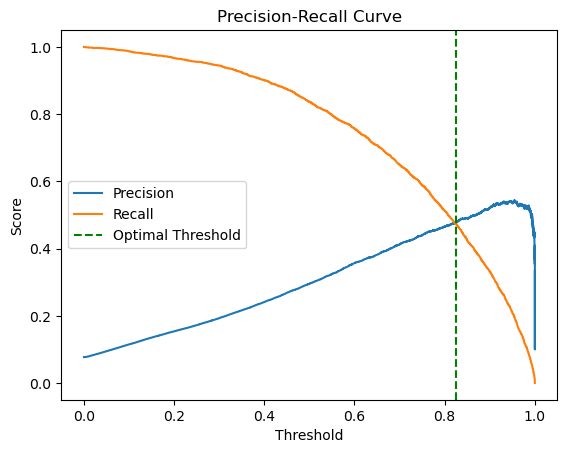

In [153]:
from sklearn.metrics import precision_recall_curve

y_pred_proba = pipeline.model.predict_proba(dataset.X_test, dataset.y_test)
precisions, recalls, thresholds = precision_recall_curve(dataset.y_test, y_pred_proba)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
optimal_threshold = 0.825
plt.axvline(optimal_threshold, color='green', linestyle='--', label='Optimal Threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

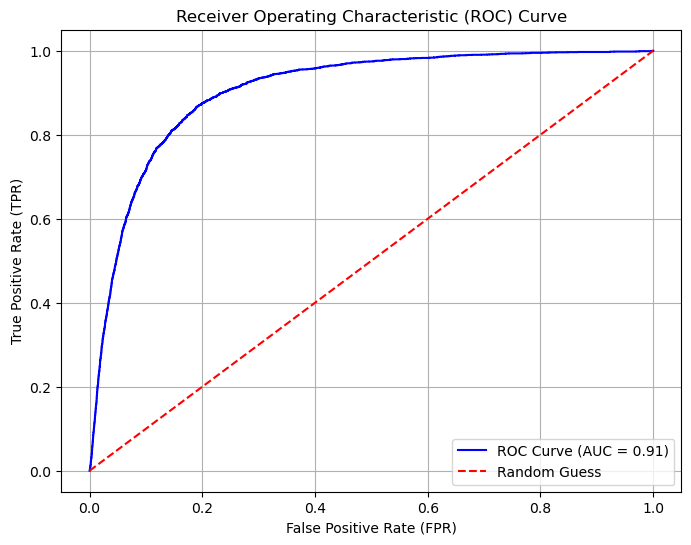

In [154]:
from sklearn.metrics import roc_curve, roc_auc_score

# compute ROC curve
fpr, tpr, thresholds = roc_curve(dataset.y_test, y_pred_proba)

# compute AUC score
roc_auc = roc_auc_score(dataset.y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
s3 = S3(bucket_name='capstone-hmis')
dataset = s3.read_dataset(config["dataset_name"])

dataset.X_train.drop(columns=["appearswostablehousing"], axis=1, inplace=True)
feature_names = dataset.X_train.columns
for idx, feature in enumerate(feature_names):
    print(f'"{feature}",')

"amindaknative",
"asian",
"blackafamerican",
"hispaniclatinaeo",
"mideastnafrican",
"nativehipacific",
"white",
"racenone",
"woman",
"man",
"nonbinary",
"culturallyspecific",
"transgender",
"questioning",
"differentidentity",
"gendernone",
"veteranstatus",
"enrollmentage",
"totalmonthlyincome",
"benefitsfromanysource",
"exittotalmonthlyincome",
"exitbenefitsfromanysource",
"physicaldisability",
"basicneedsservice",
"casemanagementservice",
"benefitsassistanceservice",
"permanenthousingguidanceservice",
"financialsupportservice",
"moveinandrentalassistanceservice",
"travelservice",
"familyservicesservice",
"harmandcrisisinterventionservice",
"foodandwaterservice",
"mentalhealthsupportservice",
"substanceabusesupportservice",
"healthcareassistanceservice",
"employmentsupportservice",
"educationsupportservice",
"temporaryhousingguidanceservice",
"travelassistanceservice",
"hygienesuppliesservice",
"documentsupportservice",
"petsupportservice",
"lifeskillsservice",
"communitysupportservice